# Loading Data, Packages

In [33]:
# loading packages
import pandas as pd
import numpy as np
import re

# load spambase dataset PC
# df=pd.read_csv(r"C:\Users\Jent\Documents\College\Emory\Machine Learning II\Assignment 3\spambase.data",header=None)

# load spambase dataset LAPTOP
df=pd.read_csv(r"C:\Users\jentl\Documents\Emory\Spring 2022\Machine Learning II\Assignment 3\spambase.data",header=None)

In [34]:
# turning off warnings for better readability
import warnings
warnings.filterwarnings('ignore') #'ignore' to turn warnings off, 'default' to restore 

In [35]:
# getting column names, PC
#with open(r"C:\Users\Jent\Documents\College\Emory\Machine Learning II\Assignment 3\spambase.names") as f:
#    lines = f.readlines()

# getting column names, LAPTOP
with open(r"C:\Users\jentl\Documents\Emory\Spring 2022\Machine Learning II\Assignment 3\spambase.names") as f:
    lines = f.readlines()

# initialize empty list
newlist = []
for x in lines:
     split_results = x.split(':')
     newlist.append(split_results[0])

colnames=[x for x in newlist if x.startswith(('w', 'c'))]
colnames.append('spam')

In [36]:
# adding column names to df
df.columns=colnames

In [37]:
# renaming columns due to errors in modeling stage
df=df.rename(columns={'char_freq_;':'char_freq_semi_colon',
                   'char_freq_(':'char_freq_paren',
                  'char_freq_[':'char_freq_bracket'})

## EDA
Spam=1, Non-Spam=0

In [38]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_semi_colon,char_freq_paren,char_freq_bracket,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [39]:
# count of target variable
df.spam.value_counts()

0    2788
1    1813
Name: spam, dtype: int64

In [40]:
df.spam.value_counts(normalize=True)

0    0.605955
1    0.394045
Name: spam, dtype: float64

### Commentary
There is a class imbalance between spam and not spam which may need addressing

In [41]:
# comparing mean of features by spam/not spam
df.groupby('spam').mean()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_semi_colon,char_freq_paren,char_freq_bracket,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
spam,,,,,,,,,,,,,,,,,,,,,
0,0.073479,0.244466,0.200581,0.000886,0.181040,0.044544,0.009383,0.038415,0.038049,0.167170,...,0.051227,0.050281,0.158578,0.022684,0.109984,0.011648,0.021713,2.377301,18.214491,161.470947
1,0.152339,0.164650,0.403795,0.164672,0.513955,0.174876,0.275405,0.208141,0.170061,0.350507,...,0.002101,0.020573,0.108970,0.008199,0.513713,0.174478,0.078877,9.519165,104.393271,470.619415


## Data Cleaning

In [42]:
# checking for nulls
df.isnull().values.any()

False

In [43]:
# checking for duplicate rows
print(np.round(df.duplicated().sum()/len(df),2), 'percent of the data are duplicate rows')

0.08 percent of the data are duplicate rows


In [44]:
# dropping duplicate rows
df=df.drop_duplicates()

# Modeling: Highest Overall Accuracy


In [45]:
# Imports for modeling
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [46]:
# shuffling dataframe so that it is not ordered by spam/not spam
df = df.sample(frac=1).reset_index(drop=True)

In [47]:
# Setting features, target variable
X, y=df.iloc[:,:-1],df.iloc[:,-1]

## XGBoost
This XGBoost pipeline setup with hyperparameter tuning via randomized search is based of a datacamp tutorial found here: <br>
https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/using-xgboost-in-pipelines?ex=12

In [94]:
# XGBoost Decision Tree and Hyperparameter Tuning
xgb_pipeline=Pipeline([('scaler', StandardScaler()),
                      ('xgbm',xgb.XGBClassifier(eval_metric='logloss'))])

# search parameters
params={'xgbm__subsample':np.arange(0.5,1,.5),
       'xgbm__max_depth':np.arange(3,20,1),
       'xgbm__colsample_bytree':np.arange(.1,1.05,0.05),
       'xgbm__eta':np.arange(0,1,0.05)}

rs=RandomizedSearchCV(estimator=xgb_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
rs.fit(X,y)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgbm',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type=None,
                                                 

In [95]:
# getting results
print('best model',rs.best_estimator_)
print('best accuracy',rs.best_score_)

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbm',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.25000000000000006,
                               enable_categorical=False,
                               eta=0.15000000000000002, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.150000006, max_delta_step=0,
                               max_depth=13, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsampl

In [86]:
# cross val scores
from sklearn.model_selection import cross_val_score

rs_pipeline=Pipeline([('scaler', StandardScaler()),
                      ('xgbm',xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7500000000000002,
              enable_categorical=False, eta=0.1, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=12,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None))])

scores = cross_val_score(rs_pipeline, X, y, cv=4, scoring='accuracy')

print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

accuracy of 0.9510677441602663 with a standard deviation of 0.0032036241036288303


In [80]:
# using bayesian search to further tune hyperparameters
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

params={'xgbm__subsample':Real(0.1,1,prior='log-uniform'),
       'xgbm__max_depth':Integer(10,20),
       'xgbm__colsample_bytree':Real(0.5,1,prior='log-uniform'),
       'xgbm__eta':Real(0.01,0.5,prior='log-uniform')}

bs=BayesSearchCV(estimator=xgb_pipeline,search_spaces=params,n_iter=10,scoring='accuracy',cv=4,verbose=0)
bs.fit(X,y)

BayesSearchCV(cv=4,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('xgbm',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       enable_categorical=False,
                                                       eval_metric='logloss',
                                                       gamma=None, gpu_id=None,
                                                       importance_type=None,
                                                       interaction_constraints=None,
                                                       learning_rate=None,
         

In [81]:
# getting results
print('best model',bs.best_estimator_)
print('best accuracy',bs.best_score_)

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbm',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6960216273904202,
                               enable_categorical=False,
                               eta=0.047816552749916044, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.0478165522, max_delta_step=0,
                               max_depth=17, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsamp

In [87]:
# double-checking these results with cross-validated scoring
from sklearn.model_selection import cross_val_score

bs_pipeline=Pipeline([('scaler', StandardScaler()),
                      ('xgbm',xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6960216273904202,
                               enable_categorical=False,
                               eta=0.047816552749916044, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.0478165522, max_delta_step=0,
                               max_depth=17, min_child_weight=1,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.7213491114236009,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

scores = cross_val_score(bs_pipeline, X, y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

accuracy of 0.9496421143284262 with a standard deviation of 0.004423314872897512


### Commentary
These results are fairly good. It was suprising to see that the results of the randomized search hyperaparameter tuning slightly outperformed the bayesian search implemented to refine the random search results.

In [83]:
# Comparison of previous code blocks withouth normalization
xgbm_best=xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5433255598386683,
                               enable_categorical=False,
                               eta=0.11161172731290236, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.111611724, max_delta_step=0,
                               max_depth=18, min_child_weight=1, 
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.8932208090471943,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None)

In [84]:
scores = cross_val_score(xgbm_best, X, y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

accuracy of 0.948930314979111 with a standard deviation of 0.004006627095123382


### Commentary
Removing standard scaling decreased XGBoost performance by roughly .1%, less that one standard deviation from previous performance

In [57]:
# rerunning best model in order to extract feature importance
xgb_pipeline2=Pipeline([('scaler', StandardScaler()),
                      ('xgbm',xgbm_best)])

xgb_pipeline2.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbm',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5433255598386683,
                               enable_categorical=False,
                               eta=0.11161172731290236, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.111611724, max_delta_step=0,
                               max_depth=18, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.893220809

In [58]:
# plot feature importance: importing packages and settings
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]

### Commentary
Mapping features from XGBoost model feature importance to actual column names was difficult. Fortunately the issue had already been solved on stackoverflow. Credit to this post for the below code chunk: <br>
https://stackoverflow.com/questions/59341289/get-actual-feature-names-from-xgboost-model

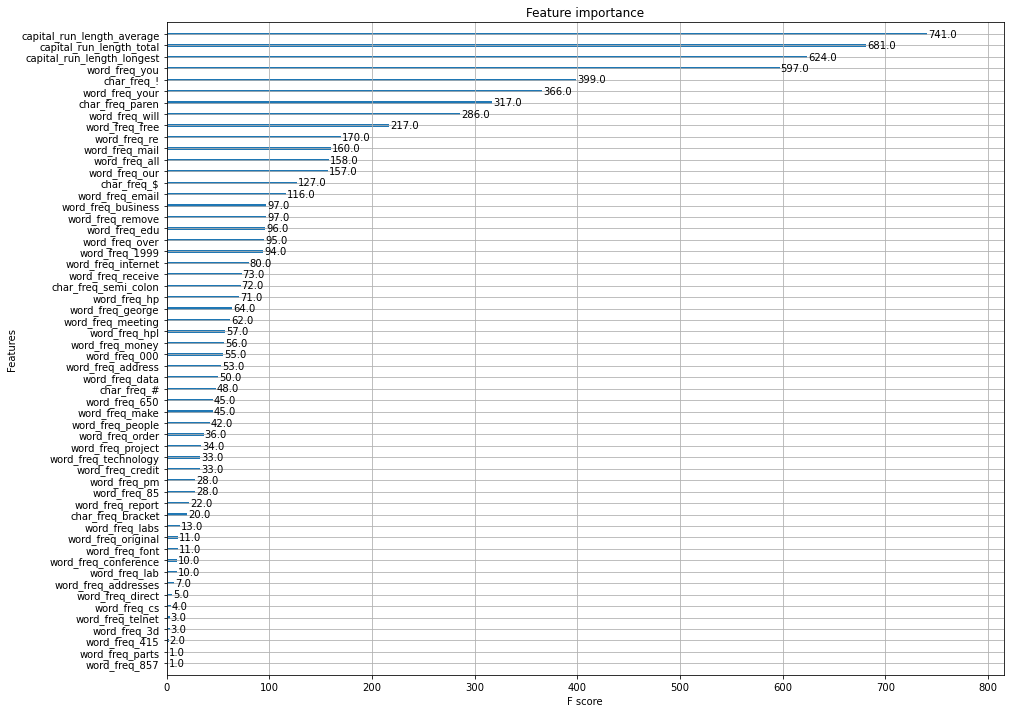

In [59]:
# create dict to use later
myfeatures = X.columns
dict_features = dict(enumerate(myfeatures))

# feat importance with names f1,f2,...
axsub = xgb.plot_importance(xgb_pipeline2['xgbm'])

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels)
plt.show()

In [96]:
# How does the model perform when dropping the 10 least important features?
scores2 = cross_val_score(rs.best_estimator_, X.drop(lst_yticklabels[0:10],axis=1), y, cv=4, scoring='accuracy')
print("accuracy of", scores2.mean(), 'with a standard deviation of', scores2.std())

accuracy of 0.9456044471887312 with a standard deviation of 0.005484584671263571


### Commentary
In the case of XGBoost model, dropping the least-predictive features has minimal impact on accuracy (less than 1%). While there appears no benefit in doing so for a dataset of this size, this ranking of features may be useful for performing feature selection for other models.

## KNN 

In [97]:
# Knn and Hyperparameter Tuning
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline=Pipeline([('scaler', StandardScaler()),
                      ('knn',KNeighborsClassifier())])

# search parameters
params={'knn__n_neighbors':np.arange(1,10,1),
       'knn__weights':['uniform','distance'],
       'knn__p':[1,2],
       'knn__leaf_size':np.arange(1,60,1)}

knnrs=RandomizedSearchCV(estimator=knn_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
knnrs.fit(X,y)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   param_distributions={'knn__leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59]),
                                        'knn__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='accuracy')

In [98]:
# getting results
print('best model',knnrs.best_estimator_)
print('best accuracy',knnrs.best_score_)

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(leaf_size=40, p=1, weights='distance'))])
best accuracy 0.9166278494542119


In [106]:
# How does dropping the least predictive features from XGBoost impact KNN's performance?
scores = cross_val_score(knnrs.best_estimator_, X.drop(lst_yticklabels[0:20],axis=1), y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

accuracy of 0.9116393862908438 with a standard deviation of 0.0025865612057134656


### KNN Feature Selection Commentary
It is interesting to see that dropping the 10, 20, and even 30 least predictive features from the XGBoost model have minimal-to-no impact on the KNN performance (dropping the 40 least predictive features, however, decreased performance by about 2%).

In [109]:
# Tuning parameters and scoring model with dropped features
knn_pipeline=Pipeline([('scaler', StandardScaler()),
                      ('knn',KNeighborsClassifier())])

# search parameters
params={'knn__n_neighbors':np.arange(1,10,1),
       'knn__weights':['uniform','distance'],
       'knn__p':[1,2]}

knn_drop_rs=RandomizedSearchCV(estimator=knn_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
knn_drop_rs.fit(X.drop(lst_yticklabels[0:25],axis=1),y)

# getting results
print('best model',knn_drop_rs.best_estimator_)
print('best accuracy',knn_drop_rs.best_score_)

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(p=1, weights='distance'))])
best accuracy 0.9194788834364245


In [110]:
# How does dropping the least predictive features from XGBoost impact KNN's performance?
scores = cross_val_score(knn_drop_rs.best_estimator_, X.drop(lst_yticklabels[0:25],axis=1), y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

accuracy of 0.9194788834364245 with a standard deviation of 0.0034814558276778152


### Knn Commentary
Feature selection slightly improved performance when the 25 least-predictive features (as provided by initial XGBoost models) were dropped (by 0.8%). 
Not included here but tested during model-building was removing normalization, which, as expected, had a significant, negative impact on model performance

In [111]:
# Naive Bayes and Hyperparameter Tuning
from sklearn.naive_bayes import GaussianNB

# setting up pipeline
gnb_pipeline=Pipeline([('scaler',StandardScaler()),
                     ('gnb',GaussianNB())])

# parameters
params={'gnb__var_smoothing':np.arange(0.00000000001,0.000005,0.00000000005)}

# random search
gnb_rs=RandomizedSearchCV(estimator=gnb_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
gnb_rs.fit(X,y)

# getting results
print('best model',gnb_rs.best_estimator_)
print('best accuracy',gnb_rs.best_score_)

# cross validated scoring
scores = cross_val_score(gnb_rs.best_estimator_, X, y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('gnb', GaussianNB(var_smoothing=4.60416e-06))])
best accuracy 0.8242264090648121
accuracy of 0.8242264090648121 with a standard deviation of 0.007607064871337719


In [118]:
# testing performance by dropping least predictive features as scored by XGBoost

accuracy_list=[]

for i in np.arange(0,50,3):
    gnb_rs.fit(X.drop(lst_yticklabels[0:i], axis=1),y)
    print('dropping', i, 'least predictive features')
    scores = cross_val_score(gnb_rs.best_estimator_, X.drop(lst_yticklabels[0:i], axis=1), y, cv=4, scoring='accuracy')
    print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())
    accuracy_list.append(scores.mean())

dropping 0 least predictive features
accuracy of 0.8242264090648121 with a standard deviation of 0.007607064871337719
dropping 3 least predictive features
accuracy of 0.8306407277414882 with a standard deviation of 0.0057317236655361715
dropping 6 least predictive features
accuracy of 0.8280277877077624 with a standard deviation of 0.005006875249644202
dropping 9 least predictive features
accuracy of 0.829215097909648 with a standard deviation of 0.0025278275652500363
dropping 12 least predictive features
accuracy of 0.830401054022727 with a standard deviation of 0.00693574316078377
dropping 15 least predictive features
accuracy of 0.8334890535460878 with a standard deviation of 0.005633074698087218
dropping 18 least predictive features
accuracy of 0.8361001881280715 with a standard deviation of 0.010783960591701709
dropping 21 least predictive features
accuracy of 0.839899535637812 with a standard deviation of 0.012754208981715677
dropping 24 least predictive features
accuracy of 0.84

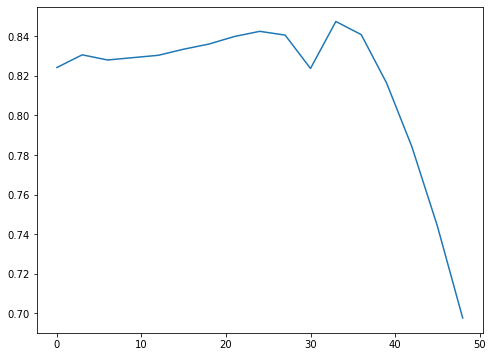

In [120]:
# visualizing results
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(np.arange(0,50,3),accuracy_list)

In [122]:
# test nb without scaling
# Naive Bayes and Hyperparameter Tuning
from sklearn.naive_bayes import GaussianNB

# setting up pipeline
gnb_pipeline=Pipeline([('gnb',GaussianNB())])

# parameters
params={'gnb__var_smoothing':np.arange(0.00000000001,0.000005,0.00000000005)}

# random search
gnb_rs=RandomizedSearchCV(estimator=gnb_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
gnb_rs.fit(X,y)

# getting results
print('best model',gnb_rs.best_estimator_)
print('best accuracy',gnb_rs.best_score_)

# cross validated scoring
scores = cross_val_score(gnb_rs.best_estimator_, X, y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

best model Pipeline(steps=[('gnb', GaussianNB(var_smoothing=1.17771e-06))])
best accuracy 0.8558215888697511
accuracy of 0.8558215888697511 with a standard deviation of 0.011578302997291854


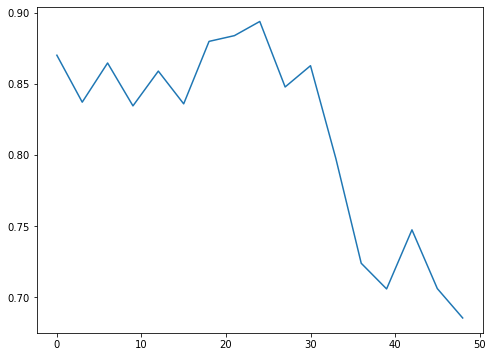

In [123]:
# checking Naive Bayes without standard scaling and feature selection

# setting up pipeline
gnb_pipeline=Pipeline([('gnb',GaussianNB())])

# parameters
params={'gnb__var_smoothing':np.arange(0.00000000001,0.000005,0.00000000005)}

accuracy_list=[]

for i in np.arange(0,50,3):
    # random search
    gnb_rs=RandomizedSearchCV(estimator=gnb_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
    gnb_rs.fit(X.drop(lst_yticklabels[0:i],axis=1),y)

    # cross validated scoring
    scores = cross_val_score(gnb_rs.best_estimator_, X.drop(lst_yticklabels[0:i],axis=1), y, cv=4, scoring='accuracy')

    accuracy_list.append(scores.mean())

plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(np.arange(0,50,3),accuracy_list)

In [132]:
# results
pd.DataFrame(data={'num_dropped_cols': np.arange(0,50,3), 'accuracy': accuracy_list}).sort_values('accuracy', ascending=False)

,num_dropped_cols,accuracy
8,24,0.893819
7,21,0.883848
6,18,0.879809
0,0,0.870069
2,6,0.864608
10,30,0.862710
4,12,0.858910
9,27,0.847749
1,3,0.837061
5,15,0.835875


### Naive Bayes Commentary
Naive Bayes classifier performed worse than XGBoost and KNN, however, by removing standard scaler and tuning the number of dropped columns, performanced improved to nearly 90% accuracy. This approach, however, suggests that perhaps a Random Forest would be more appropriate than Naive Bayes.

### notes for MLP
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

https://www.researchgate.net/publication/291833705_Optimizing_Feedforward_Neural_Networks_Using_Biogeography_Based_Optimization_for_E-Mail_Spam_Identification

In [67]:
# Feed-Forward Neural Net re: Rodan et. all
from sklearn.neural_network import MLPClassifier


In [68]:
# multi-model ensemble

In [69]:
# model performance: AUC graph

In [70]:
# Model Evaluation: cross-validation, confusion matrix, ROC curve, precision, recall, f-measure 

# Modeling: Best Cost-Sensitive Model
Using 10:1 cost ratio: <br> 
misclassifying a legitimate email as spam is 10 times more costly than classifying spam as a legitimate email

In [71]:
# Repeat previous models, optimize for cost-sensitivity

In [72]:
# Model Evaluation: cross-validation, confusion matrix, ROC curve, precision, recall, f-measure

In [73]:
# Visualization of cost-sensitivity performance

# Discussion of Results
Finally, as a deliverable, produce a write-up (i.e., a single PDF file) describing your 
aforementioned explorations. <br>
Report the performances of different models that you tried (i.e., using different data mining techniques, different attribute selection techniques, etc.) <br> 
What was the performance of the best model in the cost-unaware task (i.e., in terms of accuracy)?<br>
What was the performance of the best model in the cost-aware task (i.e., in 
terms of expected cost)?<br> 
Discuss the best models in two different tasks (as well as their performance) in detail, provide some comparisons. <br>
Draw some conclusions from the assignment.   